台灣銀行牌告匯率爬蟲練習
==
範例1： 練習爬取台幣對其他貨幣匯率資料
--


In [4]:
import requests 
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt 


進入台灣銀行牌告匯率網頁：https://rate.bot.com.tw/xrt?Lang=zh-TW ，擷取當日台幣對美金的匯率資訊
==


In [5]:
# 進入台灣銀行牌告匯率網頁，查看當日匯率資料
url = "https://rate.bot.com.tw/xrt?Lang=zh-TW"
resp = requests.get(url)
resp.encoding = 'utf-8'
# print(resp.text)  # 如有需要，列印出網頁原始碼

html = BeautifulSoup(resp.text, "lxml")
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

# 查詢美金(也就是匯率表的第一個元素)對台幣的匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 去掉空白

buy_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金買入'})
sell_rate = rate_table[0].find(name='td', attrs={'data-table':'本行現金賣出'})
print("即時現金買入: %s, 即時現金賣出: %s" % (buy_rate.get_text(), sell_rate.get_text()))


美金(USD)

即時現金買入: 28.25, 即時現金賣出: 28.92


範例2：爬取一個月的美金對台幣歷史匯率資料，並畫出趨勢圖
===


美金(USD)



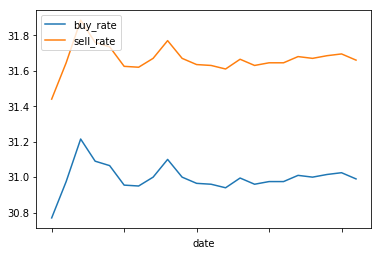

In [28]:
#先到牌告匯率首頁，爬去所有貨幣的種類
url = 'https://rate.bot.com.tw/xrt?Lang=zh-TW'
resp = requests.get(url)
resp.encoding = 'utf-8'
html = BeautifulSoup(resp.text,'lxml')
rate_table = html.find(name='table', attrs={'title':'牌告匯率'}).find(name='tbody').find_all(name='tr')

#擷取匯率表格，把美金(也就是匯率表的第一個元素)擷取出來，查詢其歷史匯率
currency = rate_table[0].find(name='div', attrs={'class':'visible-phone print_hide'})
print(currency.get_text().replace(" ", ""))  # 貨幣種類

# 針對美金，找到其「歷史匯率」的首頁 
history_link = rate_table[0].find(name='td', attrs={'data-table':'歷史匯率'})
history_rate_link = "https://rate.bot.com.tw" + history_link.a["href"]  # 該貨幣的歷史資料首頁


#
# 到貨幣歷史匯率網頁，選則該貨幣的「歷史區間」，送出查詢後，觀察其網址變化情形，再試著抓取其歷史匯率資料
#
# 用「quote/年-月」去取代網址內容，就可以連到該貨幣的歷史資料
quote_history_url = history_rate_link.replace("history", "quote/2019-08")
resp = requests.get(quote_history_url)
resp.encoding = 'utf-8'
history = BeautifulSoup(resp.text, "lxml")
history_table = history.find(name='table', attrs={'title':'歷史本行營業時間牌告匯率'}).find(name='tbody').find_all(name='tr')


#擷取到歷史匯率資料後，把資料彙整起來並畫出趨勢圖

date_history = list()
history_buy = list()
history_sell = list()

for history_rate in history_table:
    #擷取日期資料
    date_string = history_rate.a.get_text()
    date = datetime.strptime(date_string, '%Y/%M/%d').strftime('%Y/%M/%d')  # 轉換日期格式
    date_history.append(date)  # 日期歷史資料

    history_ex_rate = history_rate.find_all(name='td', attrs={'class':'rate-content-cash text-right print_table-cell'})
    history_buy.append(float(history_ex_rate[0].get_text()))  # 歷史買入匯率
    history_sell.append(float(history_ex_rate[1].get_text()))  # 歷史賣出匯率

# #將匯率資料建成dataframe形式
HistoryExchangeRate = pd.DataFrame({'date': date_history,
                                    'buy_rate':history_buy,
                                    'sell_rate':history_sell})
    
    
HistoryExchangeRate = HistoryExchangeRate.set_index('date')  # 指定日期欄位為datafram的index
HistoryExchangeRate = HistoryExchangeRate.sort_index(ascending=True)

    
#畫出歷史匯率軌跡圖
plt.figure(figsize=(10,8))
HistoryExchangeRate[['buy_rate','sell_rate']].plot()  # x=['date'], y=[['buy_rate','sell_rate']] 
plt.legend(loc="upper left")
plt.show()




